# Homework 5: Invariants, Persistence, and Safety/Liveness via Automata

In this assignment, you will extend your `TransitionSystem` class with methods for verifying system properties using finite automata. You will build a product system with an automaton, and implement checks for invariant, persistence, safety, and liveness properties.

---

In [42]:
import sys

try:
    import otter
except ImportError:
    %pip install otter-grader
    import otter

grader = otter.Notebook("HW5.ipynb")

## Provided Code


You are given the class `FiniteAutomaton`, which represents a nondeterministic finite automaton (NFA). This class includes methods for defining states, transitions, and acceptance conditions. It is useful for expressing safety and liveness properties:

```python
class FiniteAutomaton:
    Q: Set[State]              # States
    Sigma: Set[Symbol]        # Alphabet (input symbols)
    Transitions: Set[Transition]  # (state_from, symbol, state_to)
    Q0: Set[State]            # Initial states
    F: Set[State]             # Accepting states
```

You are also provided with a utility function `upholds(s, phi)` that checks whether a label set `s` satisfies a propositional formula `phi`.
### Example
```python
upholds({'a', 'b'}, 'not(a) or b')  # Returns True
upholds({'p'}, 'p and not q')      # Returns True
upholds({'q'}, 'p and not q')      # Returns False
```


Use these utilities to implement the property verification methods in the tasks below.

---

In [43]:
import re

def literals(phi):
    """
    Extracts literals from a logical expression.
    :param phi: logical expression in propositional logic.
    :return: set of literals in phi.
    """
    symbols = {'and', 'or', 'not', 'next', 'until', 'eventually', 'always', '(', ')', ' '}
    return set(re.findall(r"[\w']+", phi)) - symbols

def upholds(s, phi):
    """
    :param s: set of literals.
    :param phi: logical expression.
    :return: s |= phi

    for instance:
    upholds({'a'}, 'not(a or b) and not c') -> False
    upholds({'d'}, 'not(a or b) and not c') -> True
    upholds({'a', 'b', 'c'}, 'not(a or b) and not c') -> False
    """
    eta = {x: x in s | {'true'} for x in literals(phi)}
    return eval(phi, None, eta)

In [44]:
from typing import Set, Tuple, Optional

State = str
Symbol = str
Transition = Tuple[State, Symbol, State]


class FiniteAutomaton:
    """
    A finite automaton (NFA-style) representation.

    Attributes:
        Q (Set[State]): The set of all states.
        Sigma (Set[Symbol]): The input alphabet (symbols).
        Transitions (Set[Transition]): Transitions labeled with symbols.
        Q0 (Set[State]): The set of initial states.
        F (Set[State]): The set of accepting (final) states.
    """

    def __init__(
        self,
        states: Optional[Set[State]] = None,
        alphabet: Optional[Set[Symbol]] = None,
        transitions: Optional[Set[Transition]] = None,
        initial_states: Optional[Set[State]] = None,
        accepting_states: Optional[Set[State]] = None,
    ) -> None:
        """
        Initializes the finite automaton.

        :param states: A set of states. Defaults to an empty set.
        :param alphabet: A set of input symbols. Defaults to an empty set.
        :param transitions: A set of transitions, each as (state_from, symbol, state_to).
        :param initial_states: A set of initial states. Defaults to an empty set.
        :param accepting_states: A set of accepting states. Defaults to an empty set.
        """
        self.Q: Set[State] = set(states) if states is not None else set()
        self.Sigma: Set[Symbol] = set(alphabet) if alphabet is not None else set()
        self.Transitions: Set[Transition] = set(transitions) if transitions is not None else set()
        self.Q0: Set[State] = set(initial_states) if initial_states is not None else set()
        self.F: Set[State] = set(accepting_states) if accepting_states is not None else set()

    def add_state(self, *states: State) -> "FiniteAutomaton":
        self.Q.update(states)
        return self

    def add_symbol(self, *symbols: Symbol) -> "FiniteAutomaton":
        self.Sigma.update(symbols)
        return self

    def add_transition(self, *transitions: Transition) -> "FiniteAutomaton":
        for transition in transitions:
            if not isinstance(transition, tuple) or len(transition) != 3:
                raise ValueError(f"Invalid transition format: {transition}. Expected (state_from, symbol, state_to).")
            state_from, symbol, state_to = transition
            if state_from not in self.Q or state_to not in self.Q:
                raise ValueError("Transition states must be in the state set.")
            if symbol not in self.Sigma:
                raise ValueError("Transition symbol must be in the alphabet.")
            self.Transitions.add(transition)
        return self

    def add_initial_state(self, *states: State) -> "FiniteAutomaton":
        for state in states:
            if state not in self.Q:
                raise ValueError("Initial state must be in the state set.")
            self.Q0.add(state)
        return self

    def add_accepting_state(self, *states: State) -> "FiniteAutomaton":
        for state in states:
            if state not in self.Q:
                raise ValueError("Accepting state must be in the state set.")
            self.F.add(state)
        return self

    def __repr__(self) -> str:
        return (
            f"Automaton(\n"
            f"  States: {self.Q}\n"
            f"  Alphabet: {self.Sigma}\n"
            f"  Transitions: {self.Transitions}\n"
            f"  Initial States: {self.Q0}\n"
            f"  Accepting States: {self.F}\n"
            f")"
        )

## Part 1: Product with Finite Automaton

You will first implement:

```python
def product(self, a: "FiniteAutomaton") -> "TransitionSystem":
    pass
```

### Explanation

This method constructs a synchronous product between a transition system (TS) and a finite automaton (FA). The result is a new TS whose states are pairs `(s, q)` combining a TS state `s` and an FA state `q`. The product progresses by matching TS transitions with compatible automaton transitions.

A transition `((s, q), act, (t, p))` exists in the product iff:

- `(s, act, t)` is a TS transition
- `(q, phi, p)` is an FA transition
- `phi` holds in `t`'s label

### Example

Suppose:

- TS has transition `s0 --a--> s1` where `L(s1) = {p}`
- FA has transition `q0 --'p'--> q1`

Then the product will include `((s0, q0), a, (s1, q1))`.

---

## Part 2: Invariant and Persistence Checking

You will implement:

```python
def verify_invariant(self, k: str) -> bool:
    pass
```

### Explanation

This method returns `True` if **all reachable states** of the TS satisfy the formula `k`, and `False` otherwise.

### Example

If `k = 'p'`, and every reachable state from the initial state has `'p'` in its label, then the invariant holds.

---

```python
def verify_persistence(self, k: str) -> bool:
    pass
```

### Explanation

This method checks whether `k` eventually holds in all **future reachable states** from a point.

### Example

If `k = 'p'`, and there exists a state where `'p'` holds, but `'p'` is violated in some successor state, the persistence property does not hold.

---

## Part 3: Safety and Liveness Verification

You will implement:

```python
def verify_safety(self, a: "FiniteAutomaton") -> bool:
    pass
```

### Explanation

This method checks if **any bad prefix** is accepted by the automaton `a`. The language of `a` is assumed to be the set of **bad prefixes** of a safety property.

### Example

If `a` accepts a trace prefix that occurs in the TS, then the safety property is violated and the method returns `False`.

---

```python
def verify_liveness(self, a: "FiniteAutomaton") -> bool:
    pass
```

### Explanation

This method verifies that **no infinite execution** of the TS satisfies the language of the automaton `a`, which accepts all behaviors that **violate** a liveness property.


### Example

Suppose `a` accepts all infinite sequences where `'p'` never holds. If the TS has an execution where `'p'` is never satisfied, liveness fails and the method returns `False`.


In [45]:
from typing import Set, Dict, Tuple, Union, Optional
try:
    import networkx as nx
    import matplotlib.pyplot as plt
except ImportError:
    %pip install networkx matplotlib
    import networkx as nx
    import matplotlib.pyplot as plt

State = Union[str, Tuple]  # A state can be a string or a tuple (location, environment)
Action = str  # Actions are represented as strings
Transition = Tuple[State, Action, State]  # (source_state, action, target_state)
LabelingMap = Dict[State, Set[str]]  # Maps states to atomic propositions


class TransitionSystem:
    """
    A Transition System (TS) representation.

    Attributes:
        S (Set[State]): The set of all states (strings or tuples).
        Act (Set[Action]): The set of all possible actions.
        Transitions (Set[Transition]): The set of transitions, each represented as (state_origin, action, state_target).
        I (Set[State]): The set of initial states.
        AP (Set[str]): The set of atomic propositions.
        _L (LabelingMap): A dictionary mapping states to their respective atomic propositions.
    """

    def __init__(
        self,
        states: Optional[Set[State]] = None,
        actions: Optional[Set[Action]] = None,
        transitions: Optional[Set[Transition]] = None,
        initial_states: Optional[Set[State]] = None,
        atomic_props: Optional[Set[str]] = None,
        labeling_map: Optional[LabelingMap] = None,
    ) -> None:
        """
        Initializes the Transition System.

        :param states: A set of states (each a string or a tuple). Defaults to an empty set.
        :param actions: A set of actions. Defaults to an empty set.
        :param transitions: A set of transitions, each as (state_origin, action, state_target). Defaults to an empty set.
        :param initial_states: A set of initial states. Defaults to an empty set.
        :param atomic_props: A set of atomic propositions. Defaults to an empty set.
        :param labeling_map: A dictionary mapping states to sets of atomic propositions. Defaults to an empty dictionary.
        """
        self.S: Set[State] = set(states) if states is not None else set()
        self.Act: Set[Action] = set(actions) if actions is not None else set()
        self.Transitions: Set[Transition] = set(transitions) if transitions is not None else set()
        self.I: Set[State] = set(initial_states) if initial_states is not None else set()
        self.AP: Set[str] = set(atomic_props) if atomic_props is not None else set()
        self._L: LabelingMap = dict(labeling_map) if labeling_map is not None else {}

    def add_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the transition system.

        :param states: One or more states (strings or tuples) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.S.update(states)
        return self

    def add_action(self, *actions: Action) -> "TransitionSystem":
        """
        Adds one or more actions to the transition system.

        :param actions: One or more actions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.Act.update(actions)
        return self

    def add_transition(self, *transitions: Transition) -> "TransitionSystem":
        """
        Adds one or more transitions to the transition system.
        Ensures that all involved states and actions exist before adding the transitions.

        Each transition must be provided as a tuple of the form `(state_from, action, state_to)`, where:
        - `state_from` is the source state.
        - `action` is the action performed.
        - `state_to` is the resulting state.

        :param transitions: One or more transitions, each as a tuple `(state_from, action, state_to)`.
        :raises ValueError:
            - If a transition is not a tuple of length 3.
            - If `state_from` or `state_to` does not exist in `self.S`.
            - If `action` is not in `self.Act`.
        :return: The `TransitionSystem` instance (for method chaining).
        """
        for transition in transitions:
            if not isinstance(transition, tuple) or len(transition) != 3:
                raise ValueError(f"Invalid transition format: {transition}. Expected (state_from, action, state_to).")

            state_from, action, state_to = transition

            if state_from not in self.S:
                raise ValueError(f"State {state_from} is not in the transition system.")
            if state_to not in self.S:
                raise ValueError(f"State {state_to} is not in the transition system.")
            if action not in self.Act:
                raise ValueError(f"Action {action} is not in the transition system.")

            self.Transitions.add(transition)
        return self

    def add_initial_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the set of initial states.

        :param states: One or more states to be marked as initial.
        :raises ValueError: If any state does not exist in the system.
        :return: The TransitionSystem instance (for method chaining).
        """
        for state in states:
            if state not in self.S:
                raise ValueError(f"Initial state {state} must be in the transition system.")
            self.I.add(state)
        return self

    def add_atomic_proposition(self, *props: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to the transition system.

        :param props: One or more atomic propositions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.AP.update(props)
        return self

    def add_label(self, state: State, *labels: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to a given state.

        :param state: The state to label.
        :param labels: One or more atomic propositions to be assigned to the state.
        :raises ValueError: If the state is not in the system or if any label is not a valid atomic proposition.
        :return: The TransitionSystem instance (for method chaining).
        """
        if state not in self.S:
            raise ValueError(f"Cannot set labels for {state}. State is not in the transition system.")

        invalid_labels = {label for label in labels if label not in self.AP}
        if invalid_labels:
            raise ValueError(f"Cannot assign labels {invalid_labels}. They are not in the set of atomic propositions (AP).")

        self._L.setdefault(state, set()).update(labels)
        return self

    def L(self, state: State) -> Set[str]:
        """
        Retrieves the set of atomic propositions that hold in a given state.

        :param state: The state whose atomic propositions are being retrieved.
        :raises ValueError: If the state is not in the transition system.
        :return: A set of atomic propositions associated with the given state.
        """
        if state not in self.S:
            raise ValueError(f"State {state} is not in the transition system.")
        return self._L.get(state, set())

    def pre(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of predecessor states from which a given state or set of states can be reached.

        :param S: A single state (string/tuple) or a collection of states.
        :param action: (Optional) If provided, filters only the transitions that use this action.
        :return: A set of predecessor states.
        """
        if isinstance(S, (str, tuple)):
            S = {S}
        return {s_org for (s_org, act, s_target) in self.Transitions if s_target in S and (action is None or act == action)}

    def post(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of successor states reachable from a given state or a collection of states.

        :param S: A single state or a collection of states.
        :param action: (Optional) Filters transitions by this action.
        :return: A set of successor states.
        """
        if isinstance(S, (str, tuple)):
            S = {S}
        return {s_target for (s_org, act, s_target) in self.Transitions if s_org in S and (action is None or act == action)}

    def reach(self) -> Set[State]:
        """
        Computes the set of all reachable states from the initial states.

        :return: A set of reachable states.
        """
        S: Set[State] = set()
        nS: Set[State] = self.I
        while S != nS:
            S = nS
            nS = S | {s for s in self.post(S)}
        return S

    def product(self, a: "FiniteAutomaton") -> "TransitionSystem":
            """
            Constructs the synchronous product of the transition system with a finite automaton.
            """
            prod_ts = TransitionSystem()
            prod_states = {(s, q) for s in self.S for q in a.Q}
            prod_ts.S = prod_states
            prod_ts.Act = self.Act
            prod_ts.AP = set(a.Q)
            prod_ts._L = {(s, q): {q} for s, q in prod_states}

            prod_initial_states = set()
            for s0 in self.I:
                labels_s0 = self.L(s0)
                for q0 in a.Q0:
                    for q_from, phi, q_to in a.Transitions:
                        if q_from == q0 and upholds(labels_s0, phi):
                            if (s0, q_to) in prod_states:
                                prod_initial_states.add((s0, q_to))
            prod_ts.I = prod_initial_states

            prod_transitions = set()
            for s, act, t in self.Transitions:
                labels_t = self.L(t)
                for q_from, phi, p in a.Transitions:
                    if upholds(labels_t, phi):
                        source_prod_state = (s, q_from)
                        target_prod_state = (t, p)
                        if source_prod_state in prod_states and target_prod_state in prod_states:
                            prod_transitions.add((source_prod_state, act, target_prod_state))
            prod_ts.Transitions = prod_transitions

            return prod_ts



    def verify_invariant(self, k: str) -> bool:
        """
        Verifies if an invariant formula `k` holds in all reachable states.
        """
        return all(upholds(self.L(s), k) for s in self.reach())


    def verify_persistence(self, k: str) -> bool:
        """
        Verifies if the persistence property for formula `k` holds (FG k).
        This is corrected to only fail if a non-trivial (cyclic) reachable
        component avoids the terminally good states.
        """
        # 1. Find all states where the property k holds.
        s_k = {s for s in self.S if upholds(self.L(s), k)}
        if not s_k: return not self.reach()

        # 2. Find the largest set C where k is invariant.
        C = s_k.copy()
        while True:
            to_remove = {s for s in C if not self.post(s).issubset(C)}
            if not to_remove:
                break
            C.difference_update(to_remove)

        # 3. Build a graph of the system to find cycles (SCCs).
        G = nx.DiGraph()
        G.add_nodes_from(self.S)
        G.add_edges_from([(u, v) for u, _, v in self.Transitions])

        sccs = nx.strongly_connected_components(G)
        reachable = self.reach()

        # 4. A violation occurs if there is a reachable, non-trivial cycle that avoids C.
        for scc in sccs:
            if scc.isdisjoint(reachable) or not scc.isdisjoint(C):
                continue

            # Check if the SCC is a real cycle (non-trivial).
            is_non_trivial = len(scc) > 1 or (len(scc) == 1 and G.has_edge(list(scc)[0], list(scc)[0]))

            if is_non_trivial:
                return False  # Found a violating cycle.

        return True

    def verify_safety(self, a: "FiniteAutomaton") -> bool:
        """
        Verifies a safety property represented by a finite automaton `a`.
        """
        prod_ts = self.product(a)
        reachable_prod = prod_ts.reach()
        
        for _s, q in reachable_prod:
            if q in a.F:
                return False
        return True

    def verify_liveness(self, a: "FiniteAutomaton") -> bool:
        """
        Verifies a liveness property represented by a finite automaton `a`.
        """
        prod_ts = self.product(a)
        reachable_prod = prod_ts.reach()
        if not reachable_prod:
            return True

        reachable_transitions = [(u, v) for u, _, v in prod_ts.Transitions if u in reachable_prod]
        G_reachable = nx.DiGraph(reachable_transitions)
        G_reachable.add_nodes_from(reachable_prod)

        sccs = nx.strongly_connected_components(G_reachable)
        
        for scc_nodes in sccs:
            is_non_trivial = len(scc_nodes) > 1 or \
                             (len(scc_nodes) == 1 and G_reachable.has_edge(list(scc_nodes)[0], list(scc_nodes)[0]))
            
            if is_non_trivial:
                has_accepting_state = any(q in a.F for _s, q in scc_nodes)
                if has_accepting_state:
                    return False
                    
        return True


    def __repr__(self) -> str:
        """
        Returns a string representation of the Transition System.

        :return: A formatted string representation of the TS.
        """
        return (
            f"TransitionSystem(\n"
            f"  States: {self.S}\n"
            f"  Actions: {self.Act}\n"
            f"  Transitions: {self.Transitions}\n"
            f"  Initial States: {self.I}\n"
            f"  Atomic Propositions: {self.AP}\n"
            f"  Labels: {self._L}\n"
            f")"
        )


    def plot(self, title: str = "Transition System", figsize: Tuple[int, int] = (10, 6)) -> None:
        """
        Plots the Transition System as a directed graph.

        :param title: Title of the plot.
        :param figsize: Figure size for the plot.
        """
        G = nx.DiGraph()

        # Add nodes (states)
        for state in self.S:
            label = f"{state}\n{' '.join(self.L(state))}" if self.L(state) else str(state)
            print(label)
            G.add_node(state, label=label, color="blue" if state in self.I else "yellow")

        # Add edges (transitions)
        for state_from, action, state_to in self.Transitions:
            G.add_edge(state_from, state_to, label=action)

        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G)  # Positioning algorithm for layout

        # Draw nodes
        node_colors = [G.nodes[n]["color"] for n in G.nodes]
        nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, "label"), node_color=node_colors, edgecolors="black", node_size=2000, font_size=10)

        # Draw edge labels (actions)
        edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

        plt.title(title)
        plt.show()

    class NameGenerator:
        def __init__(self, short_names=True):
            self.count = 0
            self.short_names = short_names
            self.dict = {}

        def name(self, state):
            if self.short_names:
                try:
                    return self.dict[state]
                except KeyError:
                    self.count += 1
                    self.dict[state] = "S" + str(self.count)
                    return self.dict[state]
            else:
                return state

    def to_dot(self, filename: str, short_names: bool = True) -> str:
        """
        Exports the Transition System to a DOT file for visualization with Graphviz.

        :param filename: The name of the output DOT file.
        :return: The DOT string representation of the graph
        """
        nameGen = self.NameGenerator(short_names)

        dot_lines = ['digraph G {',
                    '\trankdir=RL;',
                    '\tnode [shape=rectangle, style=filled, fillcolor="lightyellow"];']

        # Add nodes (states)
        for state in self.S:
            label = f"{{{','.join(self.L(state))}}}" if self.L(state) else "{{}}"
            dot_lines.append(f'\t"{state}" [xlabel="{label}" label="{nameGen.name(state)}"];')
            if state in self.I:
                dot_lines.append(f'\t"init_{state}" [shape=point, style=invis, ];')
                dot_lines.append(f'\t"init_{state}" -> "{state}" [minlen=0.1];')

        # Add edges (transitions)
        for state_from, action, state_to in self.Transitions:
            dot_lines.append(f'\t"{state_from}" -> "{state_to}" [label="{action}"];')

        dot_lines.append("}")
        dot_string = "\n".join(dot_lines)

        # Write to file if filename is provided
        if filename:
            with open(filename, "w") as f:
                f.write(dot_string)

        return dot_string

In [46]:
grader.check("q1")

q1 results: All test cases passed!

### Test

Transition System Structure:
TransitionSystem(
  States: {'s0', 's1', 's2'}
  Actions: {'a', 'b'}
  Transitions: {('s0', 'a', 's1'), ('s2', 'b', 's2'), ('s1', 'a', 's0'), ('s1', 'b', 's2')}
  Initial States: {'s0'}
  Atomic Propositions: {'p', 'q'}
  Labels: {'s0': {'p'}, 's1': {'q'}, 's2': {'p', 'q'}}
)

Generating Plot...
s0
p
s1
q
s2
p q


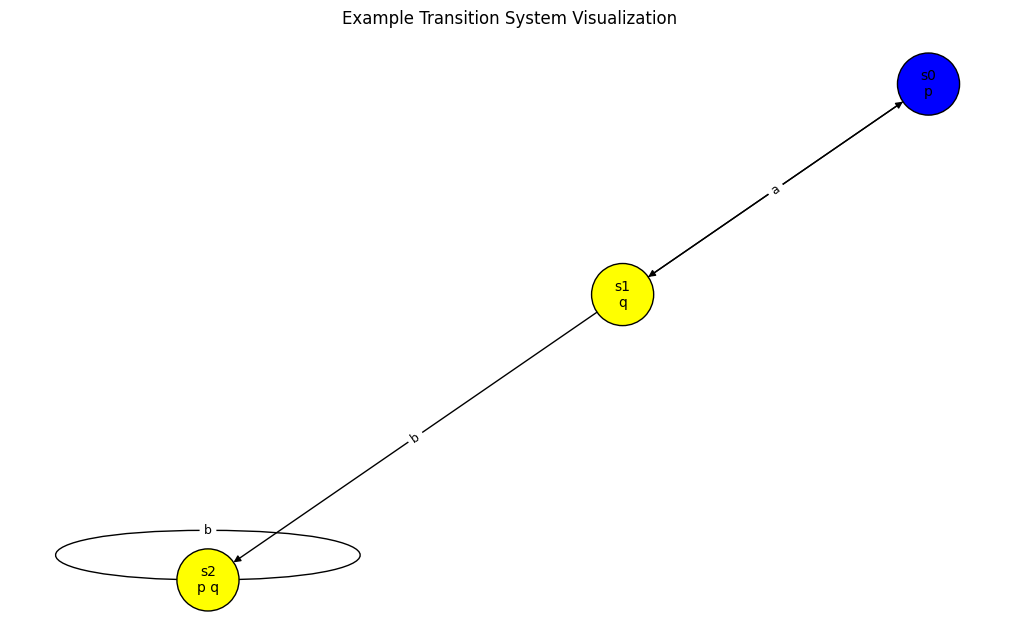

In [47]:
# 1. Create an instance of a TransitionSystem
ts_example = TransitionSystem(
    states={'s0', 's1', 's2'},
    actions={'a', 'b'},
    atomic_props={'p', 'q'},
    initial_states={'s0'}
)

# 2. Add labels to the states
ts_example.add_label('s0', 'p')
ts_example.add_label('s1', 'q')
ts_example.add_label('s2', 'p', 'q')

# 3. Add transitions between the states
# Note: The add_transition method requires states and actions to be pre-defined.
# We already did this when creating the ts_example instance.
ts_example.add_transition(
    ('s0', 'a', 's1'),
    ('s1', 'a', 's0'),  # Creates a cycle between s0 and s1
    ('s1', 'b', 's2'),
    ('s2', 'b', 's2')   # Creates a self-loop on s2
)

# 4. Print the text representation to see the structure
print("Transition System Structure:")
print(ts_example)

# 5. Generate and display the plot
print("\nGenerating Plot...")
ts_example.plot(title="Example Transition System Visualization")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [48]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)